# Stochastic Gradient Descent for MLP

In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import copy
import feedforward as ff
import pickle

In [2]:
def makeBatches(patterns, targets, batchSize):
    #returns list containing lists of batches. returns allpat[numBatches][batchSize][np.array(784,)]
    #shuffle patterns and select first batch
    allpat = []
    alltar = []
    
    #shuffle the dataset
    shuffIndex = np.random.permutation(len(patterns))
    for bat in range(int(len(patterns) // batchSize)):
        batchPat = []
        batchTar = []
        for i in range(batchSize):
            index = shuffIndex[(i + batchSize*bat)]
            #print(index, (i+batchSize*bat))
            batchPat.append(patterns[index])
            batchTar.append(targets[index])
        allpat.append(batchPat)
        alltar.append(batchTar)
    
    #if the dataset not evenly split by batches
    if len(patterns) % batchSize != 0:
        batchPat = []
        batchTar = []
        last = len(patterns) % batchSize
        for i in range(last - 1, -1, -1):
            index = shuffIndex[-(i + 1)]
            #print(index, -(i + 1))
            batchPat.append(patterns[index])
            batchTar.append(targets[index])
        allpat.append(batchPat)
        alltar.append(batchTar)
    return shuffIndex, allpat, alltar
imgtr, tartr, imgte, tarte = ff.make_dataset("mnist_train_100.csv", "mnist_test_10.csv")
ind, pat, tar = makeBatches(imgtr, tartr, 5)
print(len(pat), len(tar[2]))

100 784 100 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 1
10 10
100 100
784 10
20 5


In [4]:
def stochUpdateWeights(weights, grads):
    #update all of the weights based on the gradient
    newWeights = []
    for layer in range(len(weights)):
        weightsInLayer = weights[layer]
        gradInLayer = grads[layer]

        #subtract the gradient components from the weights
        newWeights.append(weightsInLayer - gradInLayer)
    return newWeights

In [5]:
def randomWeights(neuronsPerLayer):
    weights = []
    for layer in range(len(neuronsPerLayer) - 1):
        weights.append(np.random.randn(neuronsPerLayer[layer + 1], neuronsPerLayer[layer]))
    return weights
we = randomWeights([784, 625, 625, 10])

In [6]:
def grad(learningRate, deltas, activations, allgrads):
    #first time passed in needs proper allocated np array of zeros
    #for each layer, for each weight @ every node, calculate the gradient
    gradient = []
    for layer in range(len(allgrads) -1, -1, -1):
        deltaKs = deltas[layer]
        outJs = activations[layer]
        grad = allgrads[layer]

        #Note: [k, j] row by column. Think of matrix multiplication.
        newgrad =  learningRate * np.matmul(np.reshape(deltaKs, (len(deltaKs), 1)), np.reshape(outJs, (1, len(outJs))))
        #print(np.shape(newgrad))
        gs = newgrad + grad
        
        gradient.insert(0, gs)
    return gradient

In [56]:
def stochTrainNetwork(batch, learningRate, neuronsPerLayer, targets, weights):
    errors, grads = [], []
    numCorrect = 0
    numCorrect2 = 0

    #initialize gradient
    for layer in range(len(neuronsPerLayer) - 1):
        grads.append(np.array([[0.] * neuronsPerLayer[layer]]* neuronsPerLayer[layer + 1]))


    #Loop through all input vectors, train the network, plot the error
    for p in range(len(batch)):
        #PS: Enable this to check if the forward and backward pass are still consistent.
        #    Warning, it's very slow. Use a small network.
        #ff.gradientCheck(weights, batch[p], targets[p])

        #forward pass through network, find all activations
        activations = ff.forwardprop(batch[p], weights)

        #calculate deltas at output layer
        deltaK = ff.calcDelta(activations, targets[p])

        #calculate rest of deltas with backpropagation
        allDeltas = ff.backprop(activations, weights, deltaK)

        grads = grad(learningRate, allDeltas, activations, grads)
        
        #calculate network error
        error = ff.crossEntError(activations[-1], targets[p])
        errors.append(error)

        #Did the network guess right?
        if np.argmax(activations[-1]) == np.argmax(targets[p]):
            numCorrect += 1

        if (p % 50) == 0:
            acc = (numCorrect / (p + 1)) * 100
            #print("[iter: ", p, " loss: ", np.average(np.asarray(errors)), " right: ", numCorrect, " acc: ", acc, "%]")
    
    #update weights
    weights = stochUpdateWeights(weights, grads)
    
    #calculate accuracy and loss
    acc = (numCorrect / len(batch)) * 100
    loss = np.average(np.asarray(errors))
    
    return weights, loss, acc
we, loss, acc = stochTrainNetwork(pat[0], .05, [784, 625, 625, 10], tar[0], we)

In [19]:
def loadweights(neuronsPerLayer, filename='mnist-network'):
    try:
        we = pickle.load(open(filename, "rb"))
    except (OSError, IOError) as e:
        we = randomWeights(neuronsPerLayer)
        pickle.dump(we, open(filename, "wb"))
    return we

In [63]:
def train_stochastically(allpats, alltargs, learningRate, neuronsPerLayer, testInt= 2, checkInt= 10, filename='test-mnist'):
    #takes pre-shuffled and separated batches, trains network in batches
    losses, accs, testloss, testacc = [], [], [], []
    weights = loadweights(neuronsPerLayer, filename=filename)
    
    #first batch
    for batch in range(len(allpats)):
        weights, loss, acc = stochTrainNetwork(allpats[batch], learningRate, neuronsPerLayer, alltargs[batch], weights)

        losses.append(loss)
        accs.append(acc)
        #print("[Batch: ", batch, " Loss: ", loss, " Accuracy: ", acc, "%]")
        #print("Testing. . .")
        
        if (batch % checkInt) == 0:
            with open(filename, 'wb') as f:
                #print("Checkpoint, pickling network. . .")
                pickle.dump(weights, f)
        
        if (batch % testInt) == 0 and batch > 0:
            #print('Testing. . .')
            t, a = ff.testNetwork(imgte, tarte, weights)
            testloss.append(t)
            testacc.append(a)
        
    #plot the error
#     fig, ax = plt.subplots()
#     ax.plot(losses, marker= '.')
#     ax.set(xlabel = 'Iteration', ylabel= 'Batch Cross Entropy Error', title= 'MNIST Training Loss')
#     plt.show()

    return weights, losses, accs, testloss, testacc
plt.close('all')
#todo plot training and test loss over time, save output from each of the calls, etc.

In [48]:
def plotsave(trloss, teloss, tracc, teacc, weights, savepaths):
    fig, ax = plt.subplots()
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()
    fig4, ax4 = plt.subplots()

    accs = np.asarray(tracc).flatten()
    tests = np.asarray(teloss).flatten()
    losses = np.asarray(trloss).flatten()
    testacc = np.asarray(teacc).flatten()

    ax.plot(losses, marker= '.')
    ax.set(xlabel = 'Batch Number', ylabel= 'Batch Cross Entropy Error', title= 'MNIST Training Loss')
    ax2.plot(tests, 'm', marker= '.')
    ax2.set(xlabel= 'Batch Number', ylabel= 'Test Cross Entropy Error', title= 'Test Set Loss')
    ax3.plot(accs, marker='.')
    ax3.set(xlabel= 'Batch Number', ylabel= 'Percent Accuracy per Batch', title= 'Average Accuracy During Training')
    ax4.plot(testacc, 'm', marker='.')
    ax4.set(xlabel= 'Batch Number', ylabel= 'Percent Accuracy per Test Run', title= 'Average Accuracy of Testing')
    plt.show()
    
    with open(savepaths[0], 'wb') as f:
        print("Pickling weights. . .")
        pickle.dump(weights, f)
    with open(savepaths[1], 'wb') as f:
        print("Pickling training loss. . .")
        pickle.dump(losses, f)
    with open(savepaths[2], 'wb') as f:
        print("Pickling test loss. . .")
        pickle.dump(tests, f)
    with open(savepaths[3], 'wb') as f:
        print("Pickling training accuracy. . .")
        pickle.dump(accs, f)
    with open(savepaths[4], 'wb') as f:
        print("Pickling test accuracy. . .")
        pickle.dump(testacc, f)
#plotsave(allLoss, testLoss, trAcc, teAcc, weights, savepaths=['test-mnist.pckl', 'trl.pckl', 'tel.pckl', 'tra.pckl', 'tea.pckl'])
#del accs, tests, losses, testacc
a = pickle.load(open('tra.pckl', "rb"))

Loading training and test data
100 784 100 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 1
10 10
100 100
784 10
Starting new epoch...
Starting new epoch...
Starting new epoch...
Starting new epoch...
Starting new epoch...
Starting new epoch...
Starting new epoch...
Starting new epoch...
Starting new epoch...


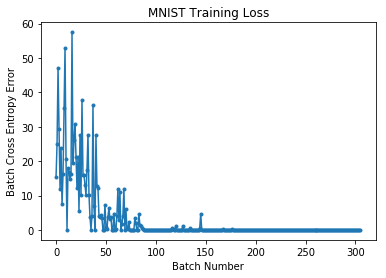

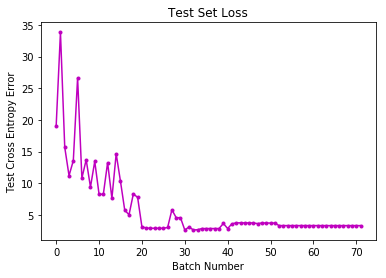

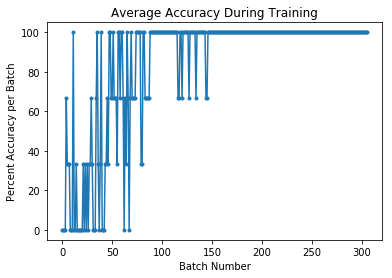

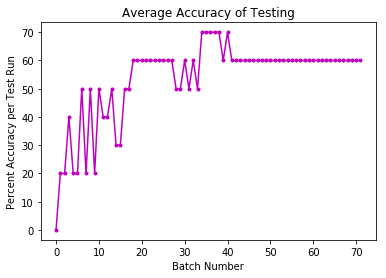

Pickling weights. . .
Pickling training loss. . .
Pickling test loss. . .
Pickling training accuracy. . .
Pickling test accuracy. . .


In [65]:
def mainstoch(trfile, tefile, params, neuronsPerLayer=[784, 625, 625, 10], savepaths=['test-mnist.pckl', 'trl.pckl', 'tel.pckl', 'tra.pckl', 'tea.pckl']):
    """runs neural network, generates loss and accuracy graphs of the training set and test set.
    trfile: filename of training data in .csv format
    tefile: filename of test data in .csv format
    params: [epochs, batchsize, learningRate, testInterval, checkptInterval]
    savepaths:[weights, trainingloss, testloss, trainingacc, testacc]"""
    
    plt.close('all')
    allLoss, testLoss, trAcc, teAcc = [], [], [], []
    
    #load and pre-process the data
    print("Loading training and test data")
    imgtr, tartr, imgte, tarte = ff.make_dataset(trfile, tefile)
    
    #how many times to pass through entire dataset
    for i in range(params[0]):
        print("Starting new epoch...")
        #Shuffle training data
        ind, pat, tar = makeBatches(imgtr, tartr, params[1])
        
        #Run stochastic gradient descent on full dataset
        weights, loss, acc, testloss, testacc = train_stochastically(pat, tar, params[2], neuronsPerLayer,
                                                                     testInt=params[3], checkInt=params[4], 
                                                                     filename=savepaths[0])
        allLoss.append(loss)
        testLoss.append(testloss)
        trAcc.append(acc)
        teAcc.append(testacc)
        
    plotsave(allLoss, testLoss, trAcc, teAcc, weights, savepaths)

params=[9, 3, .05, 4, 10]
mainstoch("mnist_train_100.csv", "mnist_test_10.csv", params, [784, 625, 625, 10])